#  Data Aggregation and Group Operations

In [1]:
import pandas as pd
import numpy as np

np.random.seed(0)

pandas provides a flexible `groupby` interface, enabling you to slice, dice, and summarize datasets in a natural way.

In this notebook, you will learn how to:
* Split a pandas object into pieces using one or more keys (in the form of functions, arrays, or DataFrame column names)
* Calculate group summary statistics, like count, mean, or standard deviation, or a user-defined function
* Apply within-group transformations or other manipulations, like normalization, linear regression, rank, or subset selection
* Compute pivot tables and cross-tabulations
* Perform quantile analysis and other statistical group analyses

**Aggregation of time series data, a special use case of `groupby`, is referred to as `resampling` and will receive separate noteook.**

## GroupBy Mechanics

group operations: split -> apply -> combine

* Data contained in a pandas object is **split** into groups based on one or more **keys** that you provide.

* The splitting is performed on a particular axis of an object. For example, a DataFrame can be grouped on its rows (axis=0) or its columns (axis=1). 

* A function is applied to each group, producing a new value. 

* The results of all those function applications are combined into a result object.  The form of the resulting object will usually depend on what’s being done to the data. 

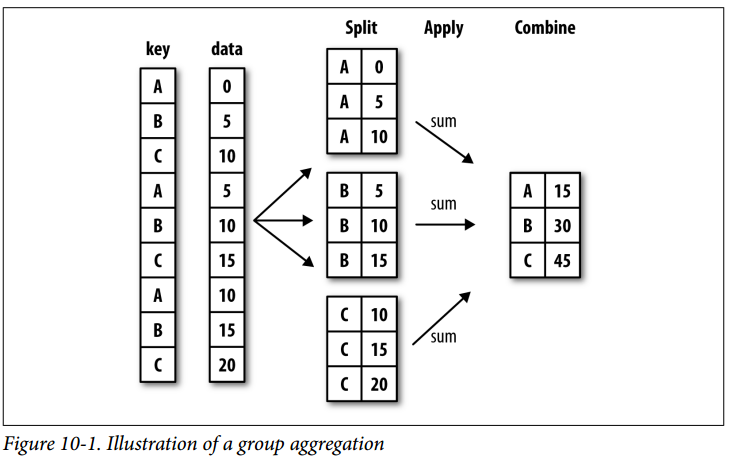

Each grouping key can take many forms, and the keys do not have to be all of the same type:
* A list or array of values that is the same length as the axis being grouped
* A value indicating a column name in a DataFrame
* A dict or Series giving a correspondence between the values on the axis being grouped and the group names
* A function to be invoked on the axis index or the individual labels in the index

**The latter three methods are shortcuts for producing an array of values to be used to split up the object.**

In [2]:
df = pd.DataFrame(
    {
        "key1": ["a", "a", "b", "b", "a"],
        "key2": ["one", "two", "one", "two", "one"],
        "data1": np.random.randint(0, 5, 5),
        "data2": np.random.randint(0, 5, 5),
    }
)

In [3]:
df

,key1,key2,data1,data2
0,a,one,4,1
1,a,two,0,3
2,b,one,3,2
3,b,two,3,4
4,a,one,3,0


Suppose you wanted to compute the mean of the *data1* column using the labels from *key1*. There are a number of ways to do this. One is to access *data1* and call `groupby` with the column (a Series) at *key1*:

In [4]:
grouped = df["data1"].groupby(df["key1"])

In [5]:
grouped

This grouped variable is now a `GroupBy` object. 
It has not actually computed anything yet except for some intermediate data about the group key `df['key1']`. 

The idea is that this object has all of the information needed to then apply some operation to each of the groups. For example, to compute group means we can call the `GroupBy`'s mean method:

In [6]:
grouped.mean()

key1
a    2.333333
b    3.000000
Name: data1, dtype: float64

In [7]:
df.groupby(["key2"]).count()

,key1,data1,data2
key2,,,
one,3,3,3
two,2,2,2


In [8]:
df.groupby("key2").mean()

,data1,data2
key2,,
one,3.333333,1.0
two,1.500000,3.5


The data (a Series) has been aggregated according to the group key, producing a new Series that is now indexed by the unique values in the *key1* column.

If instead we had passed multiple arrays as a list, we’d get something different:

In [9]:
means = df["data1"].groupby([df["key1"], df["key2"]]).mean()

In [10]:
means

key1  key2
a     one     3.5
      two     0.0
b     one     3.0
      two     3.0
Name: data1, dtype: float64

In [11]:
means.unstack()

key2,one,two
key1,,
a,3.5,0.0
b,3.0,3.0


In this example, the group keys are all Series, though they could be any arrays of the right length:

In [12]:
df

,key1,key2,data1,data2
0,a,one,4,1
1,a,two,0,3
2,b,one,3,2
3,b,two,3,4
4,a,one,3,0


In [13]:
states = np.array(["Ohio", "California", "California", "Ohio", "Ohio"])
years = np.array([2005, 2005, 2006, 2005, 2006])

In [14]:
grouped2 = df["data1"].groupby([states, years])

In [15]:
grouped2.count()

California  2005    1
            2006    1
Ohio        2005    2
            2006    1
Name: data1, dtype: int64

In [16]:
grouped2

In [17]:
grouped2.groups

{('California', 2005): [1], ('California', 2006): [2], ('Ohio', 2005): [0, 3], ('Ohio', 2006): [4]}

In [18]:
grouped2.mean()

California  2005    0.0
            2006    3.0
Ohio        2005    3.5
            2006    3.0
Name: data1, dtype: float64

Frequently the grouping information is found in the same DataFrame as the data you want to work on. In that case, you can pass column names (whether those are strings, numbers, or other Python objects) as the group keys:

In [19]:
df.groupby("key1").mean()

,data1,data2
key1,,
a,2.333333,1.333333
b,3.000000,3.000000


In [20]:
df.groupby(["key1", "key2"]).mean()

data1  data2
key1 key2              
a    one     3.5    0.5
     two     0.0    3.0
b    one     3.0    2.0
     two     3.0    4.0

In [21]:
df.groupby(["key1", "key2"])["data1"].mean()

key1  key2
a     one     3.5
      two     0.0
b     one     3.0
      two     3.0
Name: data1, dtype: float64

In [22]:
df.groupby(["key1", "key2"]).mean()["data1"]

key1  key2
a     one     3.5
      two     0.0
b     one     3.0
      two     3.0
Name: data1, dtype: float64

In the first case `df.groupby('key1').mean()` note that there is no *key2* column in the result because `df['key2']` is **not numeric data**. It is said to be a nuisance column, which is therefore excluded from the result. 

**By default, all of the numeric columns are aggregated, though it is possible to filter down to a subset**, as you'll see soon.

A generally useful `GroupBy` method is `size`, which returns a Series containing group sizes:

In [23]:
df.groupby(["key1", "key2"]).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

## Iterating Over Groups

The GroupBy object supports iteration, generating a sequence of 2-tuples containing:

**the group name along with the chunk of data**. 

In [24]:
for name, group in df.groupby("key1"):
    print(f"Data for group {name}:\n {group}\n")

Data for group a:
   key1 key2  data1  data2
0    a  one      4      1
1    a  two      0      3
4    a  one      3      0

Data for group b:
   key1 key2  data1  data2
2    b  one      3      2
3    b  two      3      4



In the case of multiple keys, the first element in the tuple will be **a tuple of key values**:

In [25]:
for (k1, k2), group in df.groupby(["key1", "key2"]):
    print((k1, k2))
    print(group)

('a', 'one')
  key1 key2  data1  data2
0    a  one      4      1
4    a  one      3      0
('a', 'two')
  key1 key2  data1  data2
1    a  two      0      3
('b', 'one')
  key1 key2  data1  data2
2    b  one      3      2
('b', 'two')
  key1 key2  data1  data2
3    b  two      3      4


A recipe you may find useful is computing a dict of the data pieces as a one-liner:

In [26]:
pieces = dict(list(df.groupby("key1")))

In [27]:
pieces

{'a':   key1 key2  data1  data2
 0    a  one      4      1
 1    a  two      0      3
 4    a  one      3      0,
 'b':   key1 key2  data1  data2
 2    b  one      3      2
 3    b  two      3      4}

By default groupby groups on `axis=0`, but you can group on any of the other axes. For example, we could group the columns of our example `df` here by `dtype` like so:

In [28]:
df

,key1,key2,data1,data2
0,a,one,4,1
1,a,two,0,3
2,b,one,3,2
3,b,two,3,4
4,a,one,3,0


In [29]:
df.dtypes

key1     object
key2     object
data1     int64
data2     int64
dtype: object

In [30]:
grouped = df.groupby(df.dtypes, axis=1)

In [31]:
for dtype, group in grouped:
    print(f"Data for group '{dtype}':\n {group}\n")

Data for group 'int64':
    data1  data2
0      4      1
1      0      3
2      3      2
3      3      4
4      3      0

Data for group 'object':
   key1 key2
0    a  one
1    a  two
2    b  one
3    b  two
4    a  one



## Selecting a Column or Subset of Columns

Indexing a `GroupBy` object created from a DataFrame with a column name or array of column names has the effect of column subsetting for aggregation. This means that:

In [32]:
df.groupby("key1")["data1"]
df.groupby("key1")[["data2"]]

are syntactic sugar for:

In [33]:
df["data1"].groupby(df["key1"])
df[["data2"]].groupby(df["key1"])

Especially for large datasets, it may be desirable to aggregate only a few columns. For example, in the preceding dataset, to compute means for just the *data2* column and get the result as a DataFrame, we could write:

In [34]:
df.groupby(["key1", "key2"])[["data2"]].mean()

data2
key1 key2       
a    one     0.5
     two     3.0
b    one     2.0
     two     4.0

In [35]:
df.groupby(["key1", "key2"])["data2"].mean()

key1  key2
a     one     0.5
      two     3.0
b     one     2.0
      two     4.0
Name: data2, dtype: float64

The object returned by this indexing operation is a *grouped* DataFrame if a list or array is passed or a grouped Series if only a single column name is passed as a scalar:

In [36]:
s_grouped = df.groupby(["key1", "key2"])["data2"]

In [37]:
s_grouped

In [38]:
s_grouped.mean()

key1  key2
a     one     0.5
      two     3.0
b     one     2.0
      two     4.0
Name: data2, dtype: float64

## Grouping with Dicts and Series

Grouping information may exist in a form other than an array. Let’s consider another example DataFrame:

In [39]:
people = pd.DataFrame(
    np.random.randint(0, 9, 25).reshape(5, 5),
    columns=["a", "b", "c", "d", "e"],
    index=["Joe", "Steve", "Wes", "Jim", "Travis"],
)

In [40]:
people

,a,b,c,d,e
Joe,8,1,6,7,7
Steve,8,1,5,8,4
Wes,3,0,3,5,0
Jim,2,3,8,1,3
Travis,3,3,7,0,1


In [41]:
people.iloc[2:3, [1, 2]] = np.nan  # Add a few NA values

Now, suppose I have a group correspondence for the columns and want to sum together the columns by group:

In [42]:
mapping = {"a": "red", "b": "red", "c": "blue", "d": "blue", "e": "red", "f": "orange"}

Now, you could construct an array from this dict to pass to `groupby`, but instead we can just pass the dict (I included the key 'f' to highlight that unused grouping keys are OK):

In [43]:
by_column = people.groupby(mapping, axis=1)

In [44]:
by_column

In [45]:
by_column.sum()

,blue,red
Joe,13.0,16.0
Steve,13.0,13.0
Wes,5.0,3.0
Jim,9.0,8.0
Travis,7.0,7.0


The same functionality holds for Series, which can be viewed as a fixed-size mapping:

In [46]:
map_series = pd.Series(mapping)

In [47]:
map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [48]:
people.groupby(map_series, axis=1).count()

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


## Grouping with Functions

Using Python functions is a more generic way of defining a group mapping compared with a dict or Series. Any function passed as a group key **will be called once per _index_ value, with the return values being used as the group names**. More concretely, consider the example DataFrame from the previous section, which has people’s first names as index values. Suppose you wanted to *group by the length of the names*; while you could compute an array of string lengths, it’s simpler to just pass the `len` function:

In [49]:
people

,a,b,c,d,e
Joe,8,1.0,6.0,7,7
Steve,8,1.0,5.0,8,4
Wes,3,NaN,NaN,5,0
Jim,2,3.0,8.0,1,3
Travis,3,3.0,7.0,0,1


In [50]:
people.groupby(len).count()

,a,b,c,d,e
3,3,2,2,3,3
5,1,1,1,1,1
6,1,1,1,1,1


In [51]:
people.groupby(len).sum()

,a,b,c,d,e
3,13,4.0,14.0,13,10
5,8,1.0,5.0,8,4
6,3,3.0,7.0,0,1


Mixing functions with arrays, dicts, or Series is not a problem as everything gets converted to arrays internally:

In [52]:
key_list = ["one", "one", "one", "two", "two"]

In [53]:
people.groupby([len, key_list]).min()

a    b    c  d  e
3 one  3  1.0  6.0  5  0
  two  2  3.0  8.0  1  3
5 one  8  1.0  5.0  8  4
6 two  3  3.0  7.0  0  1

## Grouping by Index Levels

A final convenience for hierarchically indexed datasets is the ability to aggregate using one of the levels of an axis index. Let’s look at an example:

In [54]:
columns = pd.MultiIndex.from_arrays(
    [["US", "US", "US", "JP", "JP"], [1, 3, 5, 1, 3]], names=["cty", "tenor"]
)
hier_df = pd.DataFrame(np.random.randint(0, 9, 20).reshape(4, 5), columns=columns)
hier_df

cty   US       JP   
tenor  1  3  5  1  3
0      0  4  7  3  2
1      7  2  0  0  4
2      5  5  6  8  4
3      1  4  8  1  1

To group by level, pass the level number or name using the `level` keyword:

In [55]:
hier_df.groupby(level="cty", axis=1).sum()

cty,JP,US
0,5,11
1,4,9
2,12,16
3,2,13


## Data Aggregation

Aggregations refer to any data transformation that produces scalar values from arrays. The preceding examples have used several of them, including `mean`, `count`, `min`, and `sum`. 

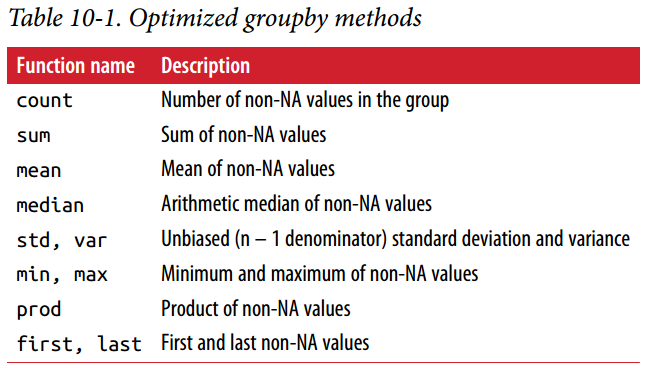

You can use aggregations of **your own devising** and additionally call any method that is also defined on the grouped object. For example, you might recall that `quantile` computes sample quantiles of a Series or a DataFrame's columns.

While quantile is not explicitly implemented for `GroupBy`, it is a Series method and thus available for use. Internally, `GroupBy` efficiently slices up the Series, calls `piece.quantile(0.9)` for each piece, and then assembles those results together into the result object:

In [56]:
df = pd.DataFrame(
    {
        "key1": ["a", "a", "b", "b", "a"],
        "key2": ["one", "two", "one", "two", "one"],
        "data1": np.random.randint(0, 5, 5),
        "data2": np.random.randint(0, 5, 5),
    }
)

In [57]:
df

,key1,key2,data1,data2
0,a,one,1,3
1,a,two,1,0
2,b,one,3,3
3,b,two,3,4
4,a,one,2,1


In [58]:
grouped = df.groupby("key1")

In [59]:
grouped["data1"].quantile(0.9)

key1
a    1.8
b    3.0
Name: data1, dtype: float64

To use your own aggregation functions, pass any function that aggregates an array to the aggregate or `agg` method:

In [62]:
def peak_to_peak(arr):
    return arr.max() - arr.min()

In [64]:
grouped[["data1", "data2"]].agg(peak_to_peak)

,data1,data2
key1,,
a,1,3
b,0,1


You may notice that some methods like `describe` also work, even though they are not aggregations:

In [65]:
grouped.describe()

data1                                             data2            \
     count      mean      std  min  25%  50%  75%  max count      mean   
key1                                                                     
a      3.0  1.333333  0.57735  1.0  1.0  1.0  1.5  2.0   3.0  1.333333   
b      2.0  3.000000  0.00000  3.0  3.0  3.0  3.0  3.0   2.0  3.500000   

                                           
           std  min   25%  50%   75%  max  
key1                                       
a     1.527525  0.0  0.50  1.0  2.00  3.0  
b     0.707107  3.0  3.25  3.5  3.75  4.0

### Column-Wise and Multiple Function Application

In [66]:
tips = pd.read_csv("data/tips.csv")

In [67]:
tips

,total_bill,tip,smoker,day,time,size
0,16.99,1.01,No,Sun,Dinner,2
1,10.34,1.66,Yes,Sat,Dinner,3
2,21.01,3.50,No,Sun,Dinner,3
3,23.68,3.31,No,Mon,Dinner,2
4,24.59,3.61,Yes,Mon,Launch,4
5,25.29,4.71,No,Sun,Dinner,4
6,16.99,1.01,No,Mon,Dinner,2
7,10.34,1.66,No,Sun,Dinner,3
8,21.01,3.50,Yes,Sat,Dinner,3
9,23.68,3.31,Yes,Sun,Launch,2


add a tipping percentage column `tip_pct`:

In [68]:
tips["tip_pct"] = tips["tip"] / tips["total_bill"]

In [69]:
tips.head()

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Yes,Sat,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Mon,Dinner,2,0.139780
4,24.59,3.61,Yes,Mon,Launch,4,0.146808


Aggregating a Series or all of the columns of a DataFrame is a matter of using aggregate with the desired function or calling a method like `mean` or `std`. 

However, you may want to aggregate using a *different function depending on the column, or multiple functions at once*. Fortunately, this is possible to do, which I'll illustrate through a number of examples. First, I'll group the tips by day and smoker:

In [70]:
grouped = tips.groupby(["day", "smoker"])

Note that for descriptive statistic, you can pass the name of the function as a string:

In [71]:
grouped_pct = grouped["tip_pct"]

In [72]:
grouped_pct.agg("mean")

day  smoker
Fri  No        0.179689
     Yes       0.059447
Mon  No        0.115345
     Yes       0.146808
Sat  Yes       0.164572
Sun  No        0.141915
     Yes       0.143294
Name: tip_pct, dtype: float64

If you pass a list of functions or function names instead, you get back a DataFrame with column names taken from the functions:

In [73]:
grouped_pct.agg(["mean", "std", peak_to_peak])

mean       std  peak_to_peak
day smoker                                  
Fri No      0.179689  0.011346      0.019652
    Yes     0.059447       NaN      0.000000
Mon No      0.115345  0.048537      0.087361
    Yes     0.146808  0.000000      0.000000
Sat Yes     0.164572  0.003491      0.006046
Sun No      0.141915  0.046176      0.126793
    Yes     0.143294  0.004969      0.007027

if you pass a list of (name, function) tuples, the first element of each tuple will be used as the DataFrame column names (you can think of a list of 2-tuples as an ordered mapping):

In [74]:
grouped_pct.agg([("foo", "mean"), ("bar", np.std)])

foo       bar
day smoker                    
Fri No      0.179689  0.011346
    Yes     0.059447       NaN
Mon No      0.115345  0.048537
    Yes     0.146808  0.000000
Sat Yes     0.164572  0.003491
Sun No      0.141915  0.046176
    Yes     0.143294  0.004969

You can specify a list of functions to apply to all of the columns or different functions per column. 
Suppose we wanted to compute the same three statistics for the `tip_pct` and `total_bill` columns:

In [77]:
functions = ["count", "mean", "max"]

In [78]:
result = grouped[["tip_pct", "total_bill"]].agg(functions)

In [79]:
result

tip_pct                     total_bill                  
             count      mean       max      count       mean    max
day smoker                                                         
Fri No           3  0.179689  0.186240          3  23.863333  25.29
    Yes          1  0.059447  0.059447          1  16.990000  16.99
Mon No           3  0.115345  0.146808          3  21.753333  24.59
    Yes          2  0.146808  0.146808          2  24.590000  24.59
Sat Yes          3  0.164572  0.166587          3  17.453333  21.01
Sun No          10  0.141915  0.186240         10  18.395000  25.29
    Yes          2  0.143294  0.146808          2  24.135000  24.59

The resulting DataFrame has hierarchical columns, the same as you would get aggregating each column separately and using `concat` to glue the results together using the column names as the `keys` argument:

In [80]:
result["tip_pct"]

count      mean       max
day smoker                           
Fri No          3  0.179689  0.186240
    Yes         1  0.059447  0.059447
Mon No          3  0.115345  0.146808
    Yes         2  0.146808  0.146808
Sat Yes         3  0.164572  0.166587
Sun No         10  0.141915  0.186240
    Yes         2  0.143294  0.146808

As before, a list of tuples with custom names can be passed:

In [81]:
ftuples = [("Durchschnitt", "mean"), ("Abweichung", np.var)]

In [83]:
grouped[["tip_pct", "total_bill"]].agg(ftuples)

tip_pct              total_bill           
           Durchschnitt Abweichung Durchschnitt Abweichung
day smoker                                                
Fri No         0.179689   0.000129    23.863333   6.106133
    Yes        0.059447        NaN    16.990000        NaN
Mon No         0.115345   0.002356    21.753333  17.224033
    Yes        0.146808   0.000000    24.590000   0.000000
Sat Yes        0.164572   0.000012    17.453333  37.949633
Sun No         0.141915   0.002132    18.395000  39.597761
    Yes        0.143294   0.000025    24.135000   0.414050

Suppose you wanted to apply potentially different functions to one or more of the columns. To do this, pass a dict to agg that contains a mapping of column names to any of the function specifications listed so far:

In [84]:
grouped.agg({"tip": np.max, "size": "sum"})

tip  size
day smoker            
Fri No      4.71    11
    Yes     1.01     2
Mon No      3.61     8
    Yes     3.61     8
Sat Yes     3.50     9
Sun No      4.71    28
    Yes     3.61     6

In [79]:
grouped.agg({"tip_pct": ["min", "max", "mean", "std"], "size": "sum"})

tip_pct                               size
                 min       max      mean       std  sum
day smoker                                             
Fri No      0.166587  0.186240  0.179689  0.011346   11
    Yes     0.059447  0.059447  0.059447       NaN    2
Mon No      0.059447  0.146808  0.115345  0.048537    8
    Yes     0.146808  0.146808  0.146808  0.000000    8
Sat Yes     0.160542  0.166587  0.164572  0.003491    9
Sun No      0.059447  0.186240  0.141915  0.046176   28
    Yes     0.139780  0.146808  0.143294  0.004969    6

A DataFrame will have hierarchical columns only if multiple functions are applied to at least one column.

## Returning Aggregated Data Without Row Indexes

In all of the examples up until now, the aggregated data comes back with an index, potentially hierarchical, composed from the unique group key combinations. Since this isn't always desirable, you can disable this behavior in most cases by passing `as_index=False` to `groupby`:

In [85]:
tips.groupby(["day", "smoker"]).mean()

total_bill       tip      size   tip_pct
day smoker                                          
Fri No       23.863333  4.306667  3.666667  0.179689
    Yes      16.990000  1.010000  2.000000  0.059447
Mon No       21.753333  2.643333  2.666667  0.115345
    Yes      24.590000  3.610000  4.000000  0.146808
Sat Yes      17.453333  2.886667  3.000000  0.164572
Sun No       18.395000  2.654000  2.800000  0.141915
    Yes      24.135000  3.460000  3.000000  0.143294

In [86]:
tips.groupby(["day", "smoker"], as_index=False).mean()

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,23.863333,4.306667,3.666667,0.179689
1,Fri,Yes,16.990000,1.010000,2.000000,0.059447
2,Mon,No,21.753333,2.643333,2.666667,0.115345
3,Mon,Yes,24.590000,3.610000,4.000000,0.146808
4,Sat,Yes,17.453333,2.886667,3.000000,0.164572
5,Sun,No,18.395000,2.654000,2.800000,0.141915
6,Sun,Yes,24.135000,3.460000,3.000000,0.143294


Of course, it's always possible to obtain the result in this format by calling `reset_index` on the result. Using the `as_index=False` method avoids some unnecessary computations.

### Apply: General split-apply-combine

The most general-purpose `GroupBy` method is **apply**. Apply splits the object being manipulated into pieces, invokes the passed function on each piece, and then attempts to concatenate the pieces together.

Suppose you wanted to select the top five `tip_pct` values by group. 
First, write a function that selects the rows with the largest values in a particular column:

In [87]:
def top(df, n=5, column="tip_pct"):
    return df.sort_values(by=column)[-n:]

In [88]:
top(tips, n=6)

,total_bill,tip,smoker,day,time,size,tip_pct
14,21.01,3.50,No,Fri,Dinner,3,0.166587
20,21.01,3.50,Yes,Sat,Dinner,3,0.166587
11,25.29,4.71,No,Sun,Dinner,4,0.186240
5,25.29,4.71,No,Sun,Dinner,4,0.186240
17,25.29,4.71,No,Fri,Launch,4,0.186240
23,25.29,4.71,No,Fri,Dinner,4,0.186240


Now, if we group by *smoker*, say, and call `apply` with this function, we get the following:

In [91]:
tips.groupby("smoker").apply(top)

total_bill   tip smoker  day    time  size   tip_pct
smoker                                                         
No     14       21.01  3.50     No  Fri  Dinner     3  0.166587
       5        25.29  4.71     No  Sun  Dinner     4  0.186240
       11       25.29  4.71     No  Sun  Dinner     4  0.186240
       17       25.29  4.71     No  Fri  Launch     4  0.186240
       23       25.29  4.71     No  Fri  Dinner     4  0.186240
Yes    16       24.59  3.61    Yes  Sun  Dinner     4  0.146808
       22       24.59  3.61    Yes  Mon  Dinner     4  0.146808
       1        10.34  1.66    Yes  Sat  Dinner     3  0.160542
       8        21.01  3.50    Yes  Sat  Dinner     3  0.166587
       20       21.01  3.50    Yes  Sat  Dinner     3  0.166587

The top function *is called on each row group from the DataFrame*, and then the results are glued together using pandas.concat, labeling the pieces with the group names. 

The result therefore has a hierarchical index whose *inner level contains index values from the original DataFrame*.
If you pass a function to apply that takes other arguments or keywords, you can pass these after the function:

In [92]:
tips.groupby(["smoker", "day"]).apply(top, n=1, column="total_bill")

total_bill   tip smoker  day    time  size   tip_pct
smoker day                                                         
No     Fri 23       25.29  4.71     No  Fri  Dinner     4  0.186240
       Mon 10       24.59  3.61     No  Mon  Dinner     4  0.146808
       Sun 11       25.29  4.71     No  Sun  Dinner     4  0.186240
Yes    Fri 12       16.99  1.01    Yes  Fri  Launch     2  0.059447
       Mon 22       24.59  3.61    Yes  Mon  Dinner     4  0.146808
       Sat 20       21.01  3.50    Yes  Sat  Dinner     3  0.166587
       Sun 16       24.59  3.61    Yes  Sun  Dinner     4  0.146808

In [93]:
tips.groupby(["smoker"]).apply(top, n=2, column="total_bill")

total_bill   tip smoker  day    time  size   tip_pct
smoker                                                         
No     17       25.29  4.71     No  Fri  Launch     4  0.186240
       23       25.29  4.71     No  Fri  Dinner     4  0.186240
Yes    16       24.59  3.61    Yes  Sun  Dinner     4  0.146808
       22       24.59  3.61    Yes  Mon  Dinner     4  0.146808

You may recall that I earlier called `describe` on a `GroupBy` object:

In [94]:
result = tips.groupby("smoker")["tip_pct"].describe()

In [95]:
result

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
No,16.0,0.144015,0.045083,0.059447,0.139780,0.160542,0.171500,0.186240
Yes,8.0,0.141671,0.034726,0.059447,0.145051,0.146808,0.162053,0.166587


In [96]:
result.unstack("smoker")

       smoker
count  No        16.000000
       Yes        8.000000
mean   No         0.144015
       Yes        0.141671
std    No         0.045083
       Yes        0.034726
min    No         0.059447
       Yes        0.059447
25%    No         0.139780
       Yes        0.145051
50%    No         0.160542
       Yes        0.146808
75%    No         0.171500
       Yes        0.162053
max    No         0.186240
       Yes        0.166587
dtype: float64

Inside `GroupBy`, when you invoke a method like `describe`, it is actually just a shortcut for:

In [101]:
grouped

In [102]:
f = lambda x: x.describe()
grouped.apply(f)

total_bill        tip       size    tip_pct
day smoker                                                   
Fri No     count    3.000000   3.000000   3.000000   3.000000
           mean    23.863333   4.306667   3.666667   0.179689
           std      2.471059   0.698594   0.577350   0.011346
           min     21.010000   3.500000   3.000000   0.166587
           25%     23.150000   4.105000   3.500000   0.176413
           50%     25.290000   4.710000   4.000000   0.186240
           75%     25.290000   4.710000   4.000000   0.186240
           max     25.290000   4.710000   4.000000   0.186240
    Yes    count    1.000000   1.000000   1.000000   1.000000
           mean    16.990000   1.010000   2.000000   0.059447
           std           NaN        NaN        NaN        NaN
           min     16.990000   1.010000   2.000000   0.059447
           25%     16.990000   1.010000   2.000000   0.059447
           50%     16.990000   1.010000   2.000000   0.059447
           75%     16.990000   1.010000   2.000000   0.059447
           max     16.990000   1.010000   2.000000   0.059447
Mon No     count    3.000000   3.000000   3.000000   3.000000
           mean    21.753333   2.643333   2.666667   0.115345
           std      4.150185   1.422439   1.154701   0.048537
           min     16.990000   1.010000   2.000000   0.059447
           25%     20.335000   2.160000   2.000000   0.099614
           50%     23.680000   3.310000   2.000000   0.139780
           75%     24.135000   3.460000   3.000000   0.143294
           max     24.590000   3.610000   4.000000   0.146808
    Yes    count    2.000000   2.000000   2.000000   2.000000
           mean    24.590000   3.610000   4.000000   0.146808
           std      0.000000   0.000000   0.000000   0.000000
           min     24.590000   3.610000   4.000000   0.146808
           25%     24.590000   3.610000   4.000000   0.146808
           50%     24.590000   3.610000   4.000000   0.146808
           75%     24.590000   3.610000   4.000000   0.146808
           max     24.590000   3.610000   4.000000   0.146808
Sat Yes    count    3.000000   3.000000   3.000000   3.000000
           mean    17.453333   2.886667   3.000000   0.164572
           std      6.160327   1.062324   0.000000   0.003491
           min     10.340000   1.660000   3.000000   0.160542
           25%     15.675000   2.580000   3.000000   0.163564
           50%     21.010000   3.500000   3.000000   0.166587
           75%     21.010000   3.500000   3.000000   0.166587
           max     21.010000   3.500000   3.000000   0.166587
Sun No     count   10.000000  10.000000  10.000000  10.000000
           mean    18.395000   2.654000   2.800000   0.141915
           std      6.292675   1.429850   0.788811   0.046176
           min     10.340000   1.010000   2.000000   0.059447
           25%     12.002500   1.660000   2.000000   0.139780
           50%     19.000000   2.485000   3.000000   0.160542
           75%     23.680000   3.452500   3.000000   0.165076
           max     25.290000   4.710000   4.000000   0.186240
    Yes    count    2.000000   2.000000   2.000000   2.000000
           mean    24.135000   3.460000   3.000000   0.143294
           std      0.643467   0.212132   1.414214   0.004969
           min     23.680000   3.310000   2.000000   0.139780
           25%     23.907500   3.385000   2.500000   0.141537
           50%     24.135000   3.460000   3.000000   0.143294
           75%     24.362500   3.535000   3.500000   0.145051
           max     24.590000   3.610000   4.000000   0.146808

### Suppressing the Group Keys

In the preceding examples, you see that the resulting object has a hierarchical index formed from the group keys along with the indexes of each piece of the original object. You can disable this by passing `group_keys=False` to groupby:

In [104]:
tips.groupby("smoker").apply(top)

total_bill   tip smoker  day    time  size   tip_pct
smoker                                                         
No     14       21.01  3.50     No  Fri  Dinner     3  0.166587
       5        25.29  4.71     No  Sun  Dinner     4  0.186240
       11       25.29  4.71     No  Sun  Dinner     4  0.186240
       17       25.29  4.71     No  Fri  Launch     4  0.186240
       23       25.29  4.71     No  Fri  Dinner     4  0.186240
Yes    16       24.59  3.61    Yes  Sun  Dinner     4  0.146808
       22       24.59  3.61    Yes  Mon  Dinner     4  0.146808
       1        10.34  1.66    Yes  Sat  Dinner     3  0.160542
       8        21.01  3.50    Yes  Sat  Dinner     3  0.166587
       20       21.01  3.50    Yes  Sat  Dinner     3  0.166587

In [105]:
tips.groupby("smoker", group_keys=False).apply(top)

,total_bill,tip,smoker,day,time,size,tip_pct
14,21.01,3.50,No,Fri,Dinner,3,0.166587
5,25.29,4.71,No,Sun,Dinner,4,0.186240
11,25.29,4.71,No,Sun,Dinner,4,0.186240
17,25.29,4.71,No,Fri,Launch,4,0.186240
23,25.29,4.71,No,Fri,Dinner,4,0.186240
16,24.59,3.61,Yes,Sun,Dinner,4,0.146808
22,24.59,3.61,Yes,Mon,Dinner,4,0.146808
1,10.34,1.66,Yes,Sat,Dinner,3,0.160542
8,21.01,3.50,Yes,Sat,Dinner,3,0.166587
20,21.01,3.50,Yes,Sat,Dinner,3,0.166587


In [106]:
tips.groupby("smoker").apply(top)

total_bill   tip smoker  day    time  size   tip_pct
smoker                                                         
No     14       21.01  3.50     No  Fri  Dinner     3  0.166587
       5        25.29  4.71     No  Sun  Dinner     4  0.186240
       11       25.29  4.71     No  Sun  Dinner     4  0.186240
       17       25.29  4.71     No  Fri  Launch     4  0.186240
       23       25.29  4.71     No  Fri  Dinner     4  0.186240
Yes    16       24.59  3.61    Yes  Sun  Dinner     4  0.146808
       22       24.59  3.61    Yes  Mon  Dinner     4  0.146808
       1        10.34  1.66    Yes  Sat  Dinner     3  0.160542
       8        21.01  3.50    Yes  Sat  Dinner     3  0.166587
       20       21.01  3.50    Yes  Sat  Dinner     3  0.166587

### Quantile and Bucket Analysis

Pandas has some tools, in particular `cut` and `qcut`, for slicing data up into buckets with bins of your choosing or by sample quantiles.

Combining these functions with `groupby` makes it convenient to perform bucket or quantile analysis on a dataset. 

Consider a simple random dataset and an equal-length bucket categorization using `cut`:

In [111]:
frame = pd.DataFrame(
    {"data1": np.random.randint(0, 100, 1000), "data2": np.random.randint(0, 100, 1000)}
)

In [112]:
frame

,data1,data2
0,7,58
1,81,60
2,31,1
3,43,17
4,41,43
...,...,...
995,12,91
996,55,86
997,48,91
998,35,3


In [115]:
quartiles, bins = pd.cut(frame["data1"], 4, retbins=True)

In [116]:
quartiles[:10]

0    (-0.099, 24.75]
1      (74.25, 99.0]
2      (24.75, 49.5]
3      (24.75, 49.5]
4      (24.75, 49.5]
5      (74.25, 99.0]
6      (24.75, 49.5]
7      (49.5, 74.25]
8      (49.5, 74.25]
9      (24.75, 49.5]
Name: data1, dtype: category
Categories (4, interval[float64, right]): [(-0.099, 24.75] < (24.75, 49.5] < (49.5, 74.25] < (74.25, 99.0]]

The `Categorical` object returned by `cut` can be passed directly to `groupby`. So we could compute a set of statistics for the *data2* column like so:

In [117]:
def get_stats(group):
    return {
        "min": group.min(),
        "max": group.max(),
        "count": group.count(),
        "mean": group.mean(),
    }

In [118]:
grouped = frame["data2"].groupby(quartiles)

In [119]:
for k, v in grouped:
    print(str(type(k)))
    print(k, v)

<class 'pandas._libs.interval.Interval'>
(-0.099, 24.75] 0      58
13     84
16     58
22      2
27     34
       ..
975    92
982    56
988    37
991    55
995    91
Name: data2, Length: 232, dtype: int64
<class 'pandas._libs.interval.Interval'>
(24.75, 49.5] 2       1
3      17
4      43
6       9
9      67
       ..
993    13
994    44
997    91
998     3
999    57
Name: data2, Length: 263, dtype: int64
<class 'pandas._libs.interval.Interval'>
(49.5, 74.25] 7      55
8      16
12     47
14     88
15     97
       ..
983    21
984    84
990    83
992    42
996    86
Name: data2, Length: 260, dtype: int64
<class 'pandas._libs.interval.Interval'>
(74.25, 99.0] 1      60
5      55
11     86
19     36
20     12
       ..
973    56
979    86
980    96
985    19
989    88
Name: data2, Length: 245, dtype: int64


In [120]:
grouped.get_group(quartiles.cat.categories[0])

0      58
13     84
16     58
22      2
27     34
       ..
975    92
982    56
988    37
991    55
995    91
Name: data2, Length: 232, dtype: int64

In [121]:
grouped.apply(get_stats).unstack()

,min,max,count,mean
data1,,,,
"(-0.099, 24.75]",0.0,99.0,232.0,49.487069
"(24.75, 49.5]",0.0,99.0,263.0,53.718631
"(49.5, 74.25]",0.0,99.0,260.0,48.388462
"(74.25, 99.0]",0.0,99.0,245.0,49.485714


These were equal-length buckets; to compute equal-size buckets based on sample quantiles, use `qcut`. I'll pass `labels=False` to just get quantile numbers:

In [122]:
grouping = pd.qcut(frame["data1"], 10)

In [123]:
grouped = frame["data2"].groupby(grouping)

In [124]:
grouped.apply(get_stats).unstack()

,min,max,count,mean
data1,,,,
"(-0.001, 9.0]",0.0,99.0,103.0,55.504854
"(9.0, 22.0]",0.0,99.0,101.0,44.821782
"(22.0, 32.7]",0.0,99.0,96.0,49.885417
"(32.7, 41.0]",0.0,99.0,109.0,53.229358
"(41.0, 50.0]",0.0,99.0,97.0,54.082474
"(50.0, 59.0]",0.0,99.0,95.0,44.442105
"(59.0, 68.0]",0.0,99.0,100.0,51.010000
"(68.0, 79.0]",0.0,99.0,105.0,48.095238
"(79.0, 88.0]",0.0,99.0,101.0,53.465347


#### Example: Filling Missing Values with Group-Specific Values

When cleaning up missing data, in some cases you will replace data observations using `dropna`, but in others you may want to impute (fill in) the null (NA) values using a fixed value or some value **derived from the data**. `fillna` is the right tool to use; for example, here I fill in NA values with the mean:

In [125]:
s = pd.Series(np.random.randint(0, 12, 6))

In [126]:
s[::2] = np.nan

In [127]:
s

0    NaN
1    5.0
2    NaN
3    6.0
4    NaN
5    1.0
dtype: float64

In [128]:
s.fillna(s.mean())

0    4.0
1    5.0
2    4.0
3    6.0
4    4.0
5    1.0
dtype: float64

Suppose you need the fill value to vary by group. One way to do this is to group the data and use **apply** with a function that calls *fillna* on each data chunk. 

Here is some sample data on US states divided into eastern and western regions:

In [129]:
states = [
    "Ohio",
    "New York",
    "Vermont",
    "Florida",
    "Oregon",
    "Nevada",
    "California",
    "Idaho",
]
group_key = ["East"] * 4 + ["West"] * 4

In [130]:
data = pd.Series(np.random.randint(0, 12, 8), index=states)

In [131]:
data

Ohio           9
New York       9
Vermont        9
Florida        5
Oregon         7
Nevada        10
California    11
Idaho          6
dtype: int64

In [132]:
group_key

['East', 'East', 'East', 'East', 'West', 'West', 'West', 'West']

Let’s set some values in the data to be missing:

In [133]:
data[["Vermont", "Nevada", "Idaho"]] = np.nan

In [134]:
data

Ohio           9.0
New York       9.0
Vermont        NaN
Florida        5.0
Oregon         7.0
Nevada         NaN
California    11.0
Idaho          NaN
dtype: float64

In [135]:
data.groupby(group_key).mean()

East    7.666667
West    9.000000
dtype: float64

We can fill the NA values using the group means like so:

In [136]:
fill_mean = lambda g: g.fillna(g.mean())

In [137]:
data.groupby(group_key).apply(fill_mean)

Ohio           9.000000
New York       9.000000
Vermont        7.666667
Florida        5.000000
Oregon         7.000000
Nevada         9.000000
California    11.000000
Idaho          9.000000
dtype: float64

In another case, you might have predefined fill values in your code that vary by group. Since the groups have a name attribute set internally, we can use that:

In [138]:
fill_values = {"East": 0.5, "West": -1}


def fill_func(g):
    return g.fillna(fill_values[g.name])

In [139]:
data.groupby(group_key).apply(fill_func)

Ohio           9.0
New York       9.0
Vermont        0.5
Florida        5.0
Oregon         7.0
Nevada        -1.0
California    11.0
Idaho         -1.0
dtype: float64

#### Example: Random Sampling and Permutation

Suppose you wanted to draw a random sample (with or without replacement) from a large dataset for Monte Carlo simulation purposes or some other application. 

There are a number of ways to perform the _draws_; here we use the `sample` method for Series.
To demonstrate, here's a way to construct a deck of English-style playing cards:

In [140]:
# Hearts, Spades, Clubs, Diamonds
suits = ["H", "S", "C", "D"]
card_val = (list(range(1, 11)) + [10] * 3) * 4
base_names = ["A"] + list(range(2, 11)) + ["J", "K", "Q"]
cards = []
for suit in ["H", "S", "C", "D"]:
    cards.extend(str(num) + suit for num in base_names)
deck = pd.Series(card_val, index=cards)

In [141]:
deck

AH      1
2H      2
3H      3
4H      4
5H      5
6H      6
7H      7
8H      8
9H      9
10H    10
JH     10
KH     10
QH     10
AS      1
2S      2
3S      3
4S      4
5S      5
6S      6
7S      7
8S      8
9S      9
10S    10
JS     10
KS     10
QS     10
AC      1
2C      2
3C      3
4C      4
5C      5
6C      6
7C      7
8C      8
9C      9
10C    10
JC     10
KC     10
QC     10
AD      1
2D      2
3D      3
4D      4
5D      5
6D      6
7D      7
8D      8
9D      9
10D    10
JD     10
KD     10
QD     10
dtype: int64

Drawing a hand of five cards from the deck could be written as:

In [142]:
def draw(deck, n=5):
    return deck.sample(n)

In [143]:
draw(deck)

10D    10
KC     10
JC     10
5C      5
2S      2
dtype: int64

Suppose you wanted two random cards from each suit. Because the suit is the last character of each card name, we can group based on this and use `apply`:

In [144]:
get_suit = lambda card: card[-1]  # last letter is suit

In [145]:
deck.groupby(get_suit).apply(draw, n=2)

C  2C      2
   8C      8
D  KD     10
   10D    10
H  8H      8
   AH      1
S  9S      9
   3S      3
dtype: int64

Alternatively, we could write:

In [146]:
deck.groupby(get_suit, group_keys=False).apply(draw, n=2)

7C     7
9C     9
QD    10
5D     5
3H     3
4H     4
5S     5
KS    10
dtype: int64

#### Example: Group Weighted Average and Correlation

Under the split-apply-combine paradigm of `groupby`, operations between columns in a DataFrame or two Series, such as a group weighted average, are possible. 

As an example, take this dataset containing group keys, values, and some weights:

In [149]:
df = pd.DataFrame(
    {
        "category": ["a", "a", "a", "a", "b", "b", "b", "b"],
        "data": np.random.randint(0, 10, 8),
        "weights": np.random.randint(0, 10, 8),
    }
)

In [150]:
df

,category,data,weights
0,a,3,6
1,a,1,0
2,a,9,9
3,a,3,8
4,b,5,0
5,b,4,8
6,b,3,4
7,b,2,3


The group weighted average by category would then be:

In [151]:
grouped = df.groupby("category")
get_wavg = lambda g: np.average(g["data"], weights=g["weights"])

In [152]:
grouped.apply(get_wavg)

category
a    5.347826
b    3.333333
dtype: float64

As another example, consider a financial dataset originally obtained from Yahoo! Finance containing end-of-day prices for a few stocks and the S&P 500 index (the SPX
symbol):

In [153]:
close_px = pd.read_csv("data/stock_px_2.csv", parse_dates=True, index_col=0)

In [154]:
close_px.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16 entries, 2009-10-01 to 2013-10-16
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    16 non-null     float64
 1   MSFT    16 non-null     float64
 2   XOM     16 non-null     float64
 3   SPX     16 non-null     float64
dtypes: float64(4)
memory usage: 640.0 bytes


In [155]:
close_px[-4:]

,AAPL,MSFT,XOM,SPX
2013-10-13,400.29,27.00,76.27,1270.54
2013-10-14,402.19,26.96,77.16,1290.25
2013-10-15,408.43,27.18,76.37,1303.66
2013-10-16,422.00,27.27,78.11,1324.58


In [160]:
close_px.corrwith(close_px["SPX"])

AAPL    0.165773
MSFT    0.162516
XOM     0.121879
SPX     1.000000
dtype: float64

One task of interest might be to compute a DataFrame consisting of the yearly correlations of daily returns (computed from percent changes) with SPX. As one way to do this, we first create a function that computes the pairwise correlation of each column with the 'SPX' column:

In [156]:
spx_corr = lambda x: x.corrwith(x["SPX"])

Next, we compute percent change on `close_px` using `pct_change`:

In [161]:
rets = close_px.pct_change().dropna()

In [162]:
rets

,AAPL,MSFT,XOM,SPX
2009-10-02,0.004747,-0.001481,0.011669,0.014687
2009-10-03,0.015515,0.008160,-0.010238,0.033860
2010-10-04,0.033225,0.003311,0.022784,0.018960
2010-10-05,-0.051445,-0.009901,-0.023557,0.023314
2010-10-06,0.004747,-0.001481,0.011669,0.010689
2011-10-07,0.015515,0.008160,-0.010238,0.015724
2011-10-08,0.033225,0.003311,0.022784,0.006153
2011-10-09,-0.051445,-0.009901,-0.023557,0.056523
2012-10-10,0.004747,-0.001481,0.011669,0.009795
2012-10-11,0.015515,0.008160,-0.010238,0.005310


Lastly, we group these percent changes by year, which can be extracted from each row label with a one-line function that returns the year attribute of each `datetime` label:

In [163]:
get_year = lambda x: x.year

In [164]:
by_year = rets.groupby(get_year)

In [165]:
by_year.apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2009,1.000000,1.000000,-1.000000,1.0
2010,-0.508281,-0.482574,-0.595778,1.0
2011,-0.999805,-0.903801,-0.834005,1.0
2012,-0.027546,-0.938382,0.875441,1.0
2013,-0.910447,-0.928857,-0.603975,1.0


You could also compute inter-column correlations. Here we compute the annual correlation between Apple and Microsoft:

In [166]:
by_year.apply(lambda g: g["AAPL"].corr(g["MSFT"]))

2009    1.000000
2010    0.999562
2011    0.895178
2012    0.371317
2013    0.874848
dtype: float64

### Example: Group-Wise Linear Regression

You can use `groupby` to perform more complex group-wise statistical analysis, as long as the function returns a *pandas object or scalar value*. For example, we can define the following `regress` function (using the `statsmodels` econometrics library), which executes an ordinary least squares (OLS) regression on each chunk of data:

In [167]:
import statsmodels.api as sm


def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X["intercept"] = 1.0
    result = sm.OLS(Y, X).fit()
    return result.params

To run a yearly linear regression of AAPL on SPX returns, execute:

In [170]:
by_year.apply(regress, "AAPL", ["SPX"])

,SPX,intercept
2009,0.561667,-0.003503
2010,-3.414657,0.055792
2011,-1.669179,0.042719
2012,-0.165536,0.019159
2013,-2.764195,0.055438


### Pivot Tables and Cross-Tabulation

A *pivot table* is a data summarization tool frequently. It aggregates a table of data by one or more keys, arranging the data in a rectangle with some of the group keys along the rows and some along the columns. 

Pivot tables in Python with pandas are made possible through the `groupby` facility combined with reshape operations utilizing hierarchical indexing. 

DataFrame has a `pivot_table` method, and there is also a top-level `pandas.pivot_table` function. 

In addition to providing a convenience interface to `groupby`, `pivot_table` can add partial totals, also known as `margins`.

Returning to the tipping dataset, suppose you wanted to compute a table of group means (the default `pivot_table` aggregation type) arranged by day and smoker on the rows:

In [171]:
tips

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Yes,Sat,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Mon,Dinner,2,0.139780
4,24.59,3.61,Yes,Mon,Launch,4,0.146808
5,25.29,4.71,No,Sun,Dinner,4,0.186240
6,16.99,1.01,No,Mon,Dinner,2,0.059447
7,10.34,1.66,No,Sun,Dinner,3,0.160542
8,21.01,3.50,Yes,Sat,Dinner,3,0.166587
9,23.68,3.31,Yes,Sun,Launch,2,0.139780


In [172]:
tips.pivot_table("tip_pct", index=["day", "smoker"])

tip_pct
day smoker          
Fri No      0.179689
    Yes     0.059447
Mon No      0.115345
    Yes     0.146808
Sat Yes     0.164572
Sun No      0.141915
    Yes     0.143294

In [173]:
tips.pivot_table(index=["day", "smoker"])

size       tip   tip_pct  total_bill
day smoker                                          
Fri No      3.666667  4.306667  0.179689   23.863333
    Yes     2.000000  1.010000  0.059447   16.990000
Mon No      2.666667  2.643333  0.115345   21.753333
    Yes     4.000000  3.610000  0.146808   24.590000
Sat Yes     3.000000  2.886667  0.164572   17.453333
Sun No      2.800000  2.654000  0.141915   18.395000
    Yes     3.000000  3.460000  0.143294   24.135000

This could have been produced with `groupby` directly. 

Now, suppose we want to aggregate only *tip_pct* and *size*, and additionally group by *time*. I’ll put *smoker* in the table columns and *day* in the rows:

In [174]:
tips.pivot_table(["tip_pct", "size"], index=["time", "day"], columns="smoker")

size        tip_pct          
smoker            No  Yes        No       Yes
time   day                                   
Dinner Fri  3.500000  NaN  0.176413       NaN
       Mon  2.666667  4.0  0.115345  0.146808
       Sat       NaN  3.0       NaN  0.164572
       Sun  3.000000  4.0  0.139863  0.146808
Launch Fri  4.000000  2.0  0.186240  0.059447
       Mon       NaN  4.0       NaN  0.146808
       Sun  2.333333  2.0  0.146701  0.139780

We could augment this table to include partial totals by passing `margins=True`. This has the effect of adding **All** row and column labels, with corresponding values being the group statistics for all the data within a single tier

In [175]:
tips.pivot_table(
    ["tip_pct", "size"], index=["time", "day"], columns="smoker", margins=True
)

size                 tip_pct                    
smoker            No    Yes    All        No       Yes       All
time   day                                                      
Dinner Fri  3.500000    NaN  3.500  0.176413       NaN  0.176413
       Mon  2.666667  4.000  3.000  0.115345  0.146808  0.123211
       Sat       NaN  3.000  3.000       NaN  0.164572  0.164572
       Sun  3.000000  4.000  3.125  0.139863  0.146808  0.140731
Launch Fri  4.000000  2.000  3.000  0.186240  0.059447  0.122843
       Mon       NaN  4.000  4.000       NaN  0.146808  0.146808
       Sun  2.333333  2.000  2.250  0.146701  0.139780  0.144971
All         2.937500  3.125  3.000  0.144015  0.141671  0.143234

Here, the *All* values are means without taking into account smoker versus nonsmoker (the *All* columns) or any of the two levels of grouping on the rows (the *All* row).

To use a different aggregation function, pass it to `aggfunc`. For example, 'count' or `len` will give you a cross-tabulation (count or frequency) of group sizes:

In [176]:
tips.pivot_table(
    "tip_pct", index=["time", "smoker"], columns="day", aggfunc=len, margins=True
)

day            Fri  Mon  Sat   Sun  All
time   smoker                          
Dinner No      2.0  3.0  NaN   7.0   12
       Yes     NaN  1.0  3.0   1.0    5
Launch No      1.0  NaN  NaN   3.0    4
       Yes     1.0  1.0  NaN   1.0    3
All            4.0  5.0  3.0  12.0   24

If some combinations are empty (or otherwise NA), you may wish to pass a `fill_value`:

In [177]:
tips.pivot_table(
    "tip_pct",
    index=["time", "size", "smoker"],
    columns="day",
    aggfunc="mean",
    fill_value=0,
)

day                      Fri       Mon       Sat       Sun
time   size smoker                                        
Dinner 2    No      0.000000  0.099614  0.000000  0.059447
       3    No      0.166587  0.000000  0.000000  0.162557
            Yes     0.000000  0.000000  0.164572  0.000000
       4    No      0.186240  0.146808  0.000000  0.186240
            Yes     0.000000  0.146808  0.000000  0.146808
Launch 2    No      0.000000  0.000000  0.000000  0.139780
            Yes     0.059447  0.000000  0.000000  0.139780
       3    No      0.000000  0.000000  0.000000  0.160542
       4    No      0.186240  0.000000  0.000000  0.000000
            Yes     0.000000  0.146808  0.000000  0.000000

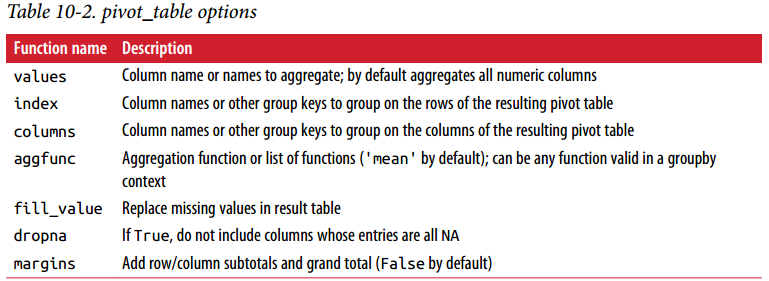

### Cross-Tabulations: Crosstab

A special case of a pivot table that computes group frequencies.

In [178]:
data = pd.read_csv("data/data.csv")

In [179]:
data

,Sample,Nationality,Handedness
0,1,USA,Right-handed
1,2,Japan,Left-handed
2,3,USA,Right-handed
3,4,Japan,Right-handed
4,5,Japan,Left-handed
5,6,Japan,Right-handed
6,7,USA,Right-handed
7,8,USA,Left-handed
8,9,Japan,Right-handed
9,10,USA,Right-handed


We might want to summarize this data by nationality and handedness. You could use `pivot_table` to do this, but the `pandas.crosstab` function can be more convenient:

In [184]:
pd.crosstab(data["Nationality"], data["Handedness"], margins=True)

Handedness,Left-handed,Right-handed,All
Nationality,,,
Japan,2,3,5
USA,1,4,5
All,3,7,10


The first two arguments to `crosstab` can each either be an array or Series or a list of arrays. As in the tips data:

In [185]:
pd.crosstab([tips["time"], tips["day"]], tips["smoker"], margins=True)

smoker      No  Yes  All
time   day              
Dinner Fri   2    0    2
       Mon   3    1    4
       Sat   0    3    3
       Sun   7    1    8
Launch Fri   1    1    2
       Mon   0    1    1
       Sun   3    1    4
All         16    8   24